In [1]:
import re
import pickle
from tqdm import tqdm
from collections import Counter

import numpy as np

from sympy import Rational, simplify
from sympy.parsing.sympy_parser import (
    parse_expr,
    standard_transformations,
    implicit_multiplication_application,
)

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

### Helper functions

In [8]:
def clean_math_answer(ans: str) -> str:
    """
    Clean and normalize a math answer string, similar to LightEval's approach,
    with support for implicit multiplication and symbolic simplification.
    
    Steps:
    - Strip whitespace and commas in numbers.
    - Remove stray $ or punctuation.
    - Parse with sympy (with implicit multiplication).
    - If numeric, reduce to rational form.
    - If symbolic, simplify and return canonical string.
    - Fallback: return normalized lowercase string.
    """
    if ans is None:
        return ""

    # Step 1: strip whitespace
    cleaned = ans.strip()
    cleaned = cleaned.replace(" ", "")

    # Step 2: remove commas in numbers
    cleaned = cleaned.replace(",", "")

    # Step 3: remove enclosing $ signs, units, or stray punctuation
    cleaned = cleaned.strip(" $")
    cleaned = re.sub(r"[ \t\n]+", " ", cleaned)  # collapse whitespace
    cleaned = cleaned.rstrip(".,")  # remove trailing punctuation

    # Step 4: try to parse with sympy (with implicit multiplication)
    try:
        expr = parse_expr(
            cleaned,
            transformations=(
                standard_transformations + (implicit_multiplication_application,)
            ),
            evaluate=True,
        )

        # Try simplifying the expression
        expr = simplify(expr)

        # If numeric, return rational string (e.g., "1/2" instead of "0.5")
        if expr.is_number:
            rat = Rational(expr)
            return str(rat) if rat.q != 1 else str(rat.p)

        # Else symbolic
        return str(expr)

    except:
        # Fallback to normalized string
        return cleaned.lower()

def majority_vote(answers):
    """
    Perform majority voting over a list of answers and return the most frequent one.
    """
    # majority vote of 3
    answers = answers[:3]
    
    # Filter out None and empty strings
    filtered = [a for a in answers if a and a.strip()]
    if not filtered:
        return None

    counts = Counter(filtered)
    max_count = max(counts.values())

    # Get all answers with max frequency
    candidates = [ans for ans, c in counts.items() if c == max_count]

    # Break ties deterministically (lexicographic order)
    return min(candidates)

# GSM8K

In [9]:
# Load the datasets
with open("/scratch/saydalie/llm_reasoning/data/outputs/Qwen3-8B/gsm8k/chunks_answer_probs.pkl", "rb") as f:
    chunk_data = pickle.load(f)

with open("/scratch/saydalie/llm_reasoning/data/outputs/Qwen3-8B/gsm8k/chunks_answer.pkl", "rb") as f:
    chunk_answers = pickle.load(f)

chunk_method = 'keywords'

# Initialize final result lists
level_acc_no_cot, level_acc_first, level_acc_last = [], [], []
level_ans_no_cot, level_ans_first, level_ans_last = [], [], []
level_cot_first, level_cot_last = [], []

for item_data in chunk_data:
    for item_answers in chunk_answers:
        if item_data['id'] == item_answers['id']:
            
            # Process answers and compute accuracies
            true_answer = clean_math_answer(item_answers['answer'])
            chunks = item_answers['chunks'][chunk_method]
            chunk_indices = [i['chunk_end_id'] for i in item_data['chunks'][chunk_method]]
            input_len = chunk_indices[0] - 1
            
            is_correct = []
            answer_lengths = []
            
            for chunk in chunks:
                predicted_answers = [clean_math_answer(answer) for answer in chunk['decoded_answers']]
                predicted_answer = majority_vote(predicted_answers)
                is_correct.append(true_answer == predicted_answer)
                answer_lengths.append(float(np.mean(chunk['answer_output_len'])))
            
            # No CoT metrics
            level_acc_no_cot.append(is_correct[0])
            level_ans_no_cot.append(answer_lengths[0])
            
            # First correct answer metrics
            if True in is_correct:
                first_correct_idx = is_correct.index(True)
                level_acc_first.append(True)
                level_ans_first.append(answer_lengths[first_correct_idx])
                level_cot_first.append(chunk_indices[first_correct_idx] - input_len)
            else:
                level_acc_first.append(False)
                level_ans_first.append(answer_lengths[-1])
                level_cot_first.append(chunk_indices[-1] - input_len)
            
            # Last answer metrics
            level_acc_last.append(is_correct[-1])
            level_ans_last.append(answer_lengths[-1])
            level_cot_last.append(chunk_indices[-1] - input_len)

# Compute means for this level and append to final lists
acc_no_cot = np.mean(level_acc_no_cot)
acc_first = np.mean(level_acc_first)
acc_last = np.mean(level_acc_last)

ans_no_cot = np.mean(level_ans_no_cot)
ans_first = np.mean(level_ans_first)
ans_last = np.mean(level_ans_last)

cot_no_cot = 0  # No CoT length is always 0
cot_first = np.mean(level_cot_first)
cot_last = np.mean(level_cot_last)

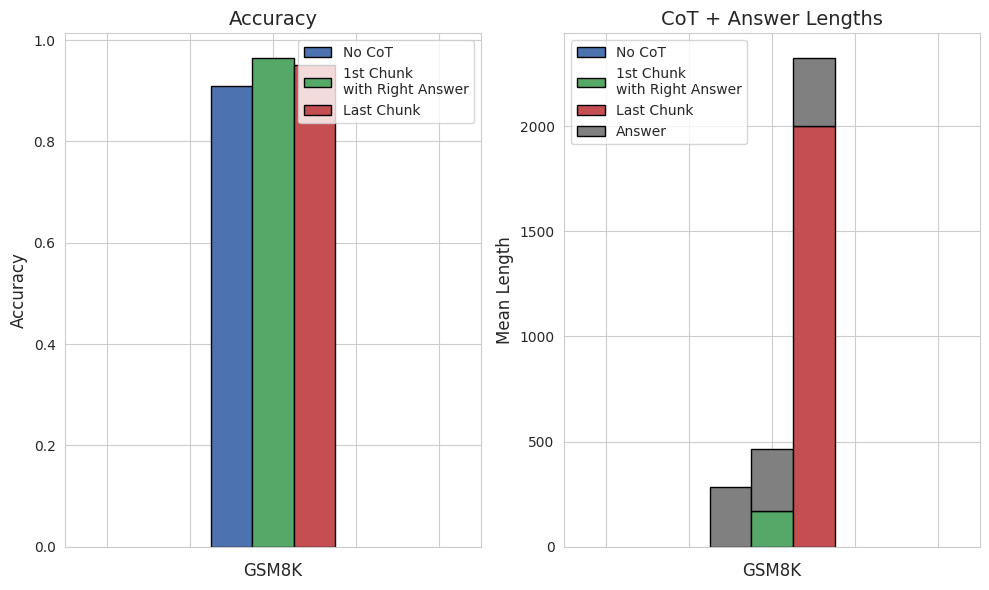

In [10]:
# Set Seaborn style for aesthetics
sns.set_style("whitegrid")

x = [0]
x_len = [0]

# ============================
# Create subplots: 1 row, 2 cols
# ============================
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

# Shared settings - scaling bar width to maintain visual appearance from (4,6) plot
bar_width = 0.25 * (4/10)  # Scale by width ratio to keep same visual size
colors = ['#4C72B0', '#55A868', '#C44E52']
border_color = 'black'
labels = ['No CoT', '1st Chunk\nwith Right Answer', 'Last Chunk']

# =====================
# Plot 1: Accuracy Plot
# =====================
x_indexes = np.arange(len(x))

axes[0].bar(x_indexes - bar_width, acc_no_cot, width=bar_width, 
            label=labels[0], color=colors[0], edgecolor=border_color)
axes[0].bar(x_indexes, acc_first, width=bar_width, 
            label=labels[1], color=colors[1], edgecolor=border_color)
axes[0].bar(x_indexes + bar_width, acc_last, width=bar_width, 
            label=labels[2], color=colors[2], edgecolor=border_color)

axes[0].set_xlabel('GSM8K', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title("Accuracy", fontsize=14)
axes[0].set_xticklabels(x, fontsize=11)
axes[0].tick_params(axis='y', labelsize=10)
axes[0].legend(fontsize=10)
axes[0].set_xlim(-0.5, 0.5)

# =====================
# Plot 2: Lengths Plot
# =====================
x_indexes_len = np.arange(len(x_len))

# --- No CoT Stack ---
axes[1].bar(x_indexes_len - bar_width, cot_no_cot, 
            width=bar_width, color=colors[0], edgecolor=border_color, label=labels[0])
axes[1].bar(x_indexes_len - bar_width, ans_no_cot, 
            width=bar_width, bottom=cot_no_cot, color='grey', edgecolor=border_color, label='Answer')

# --- First Stack ---
axes[1].bar(x_indexes_len, cot_first, 
            width=bar_width, color=colors[1], edgecolor=border_color, label=labels[1])
axes[1].bar(x_indexes_len, ans_first, 
            width=bar_width, bottom=cot_first, color='grey', edgecolor=border_color, label='_nolegend_')

# --- Last Stack ---
axes[1].bar(x_indexes_len + bar_width, cot_last, 
            width=bar_width, color=colors[2], edgecolor=border_color, label=labels[2])
axes[1].bar(x_indexes_len + bar_width, ans_last, 
            width=bar_width, bottom=cot_last, color='grey', edgecolor=border_color, label='_nolegend_')

# --- Custom legend ordering ---
handles, legend_labels = axes[1].get_legend_handles_labels()
answer_index = legend_labels.index('Answer')
handles.append(handles.pop(answer_index))
legend_labels.append(legend_labels.pop(answer_index))

axes[1].set_xlabel('GSM8K', fontsize=12)
axes[1].set_ylabel('Mean Length', fontsize=12)
axes[1].set_title("CoT + Answer Lengths", fontsize=14)
axes[1].set_xticklabels(x_len, fontsize=11)
axes[1].tick_params(axis='y', labelsize=10)
axes[1].legend(handles, legend_labels, fontsize=10)
# Set tight x-axis limits to maintain bar appearance from (4,6) plot
axes[1].set_xlim(-0.5, 0.5)

# =====================
# Final layout
# =====================
plt.tight_layout()
plt.show()

# MATH

In [11]:
levels = [1, 2, 3, 4, 5]

# Load the datasets
chunk_data = {}
chunk_answers = {}

for level in levels:
    with open(f"/scratch/saydalie/llm_reasoning/data/outputs/Qwen3-8B/math/Algebra/level_{level}/chunks_answer_probs.pkl", "rb") as f:
        chunk_data[level] = pickle.load(f)
    
    with open(f"/scratch/saydalie/llm_reasoning/data/outputs/Qwen3-8B/math/Algebra/level_{level}/chunks_answer.pkl", "rb") as f:
        chunk_answers[level] = pickle.load(f)

chunk_method = 'keywords'

# Initialize final result lists
acc_no_cot, acc_first, acc_last = [], [], []
ans_no_cot, ans_first, ans_last = [], [], []
cot_no_cot, cot_first, cot_last = [], [], []

for level in tqdm(levels):
    level_acc_no_cot, level_acc_first, level_acc_last = [], [], []
    level_ans_no_cot, level_ans_first, level_ans_last = [], [], []
    level_cot_first, level_cot_last = [], []
    
    for item_data in chunk_data[level]:
        for item_answers in chunk_answers[level]:
            if item_data['id'] == item_answers['id']:
                
                # Process answers and compute accuracies
                true_answer = clean_math_answer(item_answers['answer'])
                chunks = item_answers['chunks'][chunk_method]
                chunk_indices = [i['chunk_end_id'] for i in item_data['chunks'][chunk_method]]
                input_len = chunk_indices[0] - 1
                
                is_correct = []
                answer_lengths = []
                
                for chunk in chunks:
                    predicted_answers = [clean_math_answer(answer) for answer in chunk['decoded_answers']]
                    predicted_answer = majority_vote(predicted_answers)
                    is_correct.append(true_answer == predicted_answer)
                    answer_lengths.append(float(np.mean(chunk['answer_output_len'])))
                
                # No CoT metrics
                level_acc_no_cot.append(is_correct[0])
                level_ans_no_cot.append(answer_lengths[0])
                
                # First correct answer metrics
                if True in is_correct:
                    first_correct_idx = is_correct.index(True)
                    level_acc_first.append(True)
                    level_ans_first.append(answer_lengths[first_correct_idx])
                    level_cot_first.append(chunk_indices[first_correct_idx] - input_len)
                else:
                    level_acc_first.append(False)
                    level_ans_first.append(answer_lengths[-1])
                    level_cot_first.append(chunk_indices[-1] - input_len)
                
                # Last answer metrics
                level_acc_last.append(is_correct[-1])
                level_ans_last.append(answer_lengths[-1])
                level_cot_last.append(chunk_indices[-1] - input_len)
    
    # Compute means for this level and append to final lists
    acc_no_cot.append(np.mean(level_acc_no_cot))
    acc_first.append(np.mean(level_acc_first))
    acc_last.append(np.mean(level_acc_last))
    
    ans_no_cot.append(np.mean(level_ans_no_cot))
    ans_first.append(np.mean(level_ans_first))
    ans_last.append(np.mean(level_ans_last))
    
    cot_no_cot.append(0)  # No CoT length is always 0
    cot_first.append(np.mean(level_cot_first))
    cot_last.append(np.mean(level_cot_last))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:23<00:00,  4.62s/it]


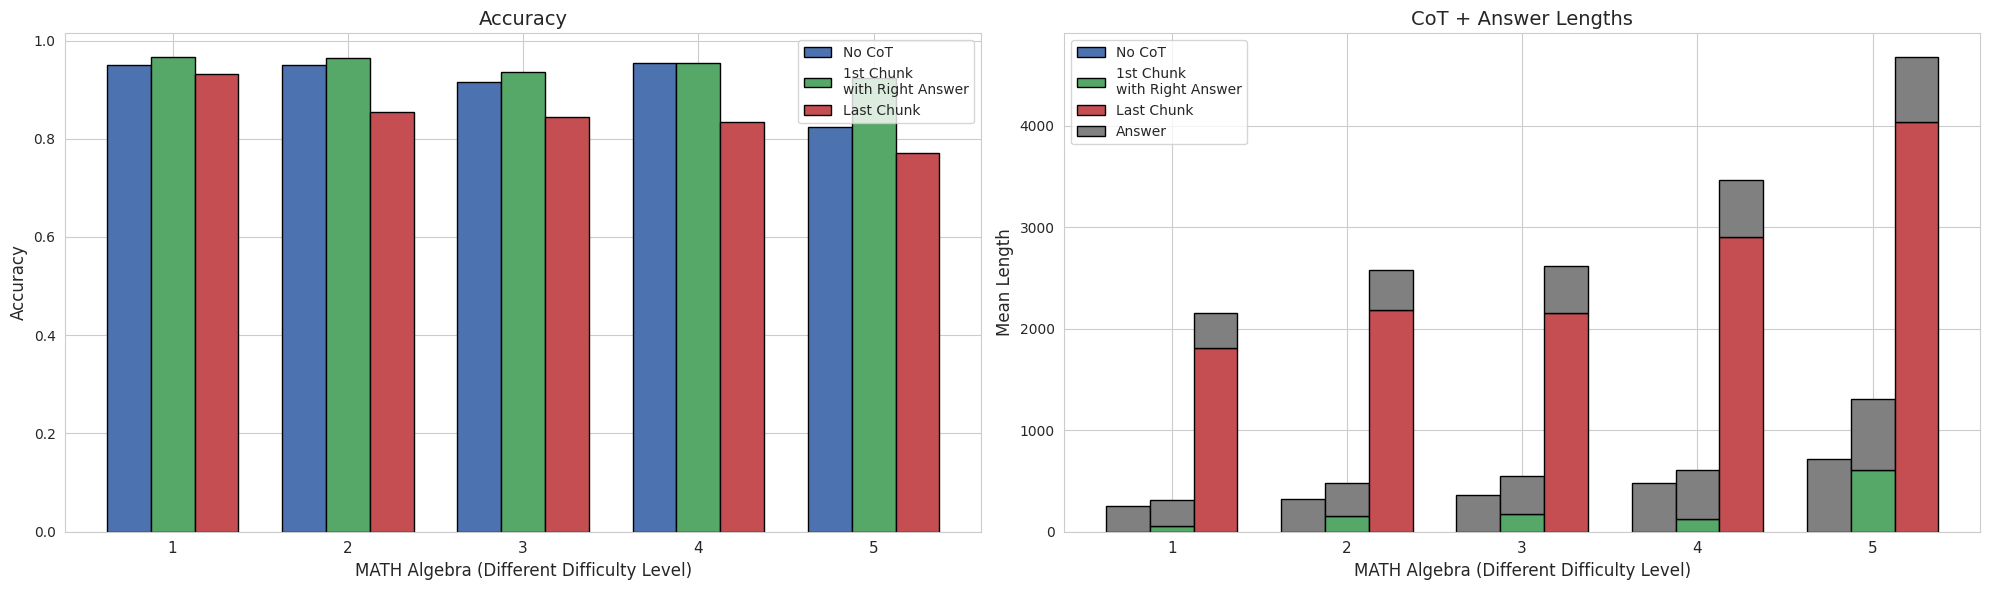

In [12]:
# Set Seaborn style for aesthetics
sns.set_style("whitegrid")

x = levels
x_len = levels

# ============================
# Create subplots: 1 row, 2 cols
# ============================
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Shared settings
bar_width = 0.25
colors = ['#4C72B0', '#55A868', '#C44E52']
border_color = 'black'
labels = ['No CoT', '1st Chunk\nwith Right Answer', 'Last Chunk']

# =====================
# Plot 1: Accuracy Plot
# =====================
x_indexes = np.arange(len(x))

axes[0].bar(x_indexes - bar_width, acc_no_cot, width=bar_width, 
            label=labels[0], color=colors[0], edgecolor=border_color)
axes[0].bar(x_indexes, acc_first, width=bar_width, 
            label=labels[1], color=colors[1], edgecolor=border_color)
axes[0].bar(x_indexes + bar_width, acc_last, width=bar_width, 
            label=labels[2], color=colors[2], edgecolor=border_color)

axes[0].set_xlabel('MATH Algebra (Different Difficulty Level)', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title("Accuracy", fontsize=14)
axes[0].set_xticks(x_indexes)
axes[0].set_xticklabels(x, fontsize=11)
axes[0].tick_params(axis='y', labelsize=10)
axes[0].legend(fontsize=10)

# =====================
# Plot 2: Lengths Plot
# =====================
x_indexes_len = np.arange(len(x_len))

# --- No CoT Stack ---
axes[1].bar(x_indexes_len - bar_width, cot_no_cot, 
            width=bar_width, color=colors[0], edgecolor=border_color, label=labels[0])
axes[1].bar(x_indexes_len - bar_width, ans_no_cot, 
            width=bar_width, bottom=cot_no_cot, color='grey', edgecolor=border_color, label='Answer')

# --- First Stack ---
axes[1].bar(x_indexes_len, cot_first, 
            width=bar_width, color=colors[1], edgecolor=border_color, label=labels[1])
axes[1].bar(x_indexes_len, ans_first, 
            width=bar_width, bottom=cot_first, color='grey', edgecolor=border_color, label='_nolegend_')

# --- Last Stack ---
axes[1].bar(x_indexes_len + bar_width, cot_last, 
            width=bar_width, color=colors[2], edgecolor=border_color, label=labels[2])
axes[1].bar(x_indexes_len + bar_width, ans_last, 
            width=bar_width, bottom=cot_last, color='grey', edgecolor=border_color, label='_nolegend_')

# --- Custom legend ordering ---
handles, legend_labels = axes[1].get_legend_handles_labels()
answer_index = legend_labels.index('Answer')
handles.append(handles.pop(answer_index))
legend_labels.append(legend_labels.pop(answer_index))

axes[1].set_xlabel('MATH Algebra (Different Difficulty Level)', fontsize=12)
axes[1].set_ylabel('Mean Length', fontsize=12)
axes[1].set_title("CoT + Answer Lengths", fontsize=14)
axes[1].set_xticks(x_indexes_len)
axes[1].set_xticklabels(x_len, fontsize=11)
axes[1].tick_params(axis='y', labelsize=10)
axes[1].legend(handles, legend_labels, fontsize=10)

# =====================
# Final layout
# =====================
plt.tight_layout()
plt.show()